# Reference
[이미지 분류](https://www.tensorflow.org/tutorials/images/classification?hl=ko)

# Workflow
1. 데이터 전처리 및 파이프라인 구축
2. 모델 구축
3. 모델 학습 및 개선
4. 모델 예측

# 1. 데이터 전처리 및 파이프라인 구축

### 라이브러리 준비

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### 데이터 다운로드

데이터: flower photos 
- 3670장
- 5종류(daisy/dandelion/roses/sunflowers/tulips)

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


###  데이터 파이프라인(전처리)
[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) 를 이용한 데이터 파이프라인을 만들 수 있다. 데이터를 `tf.data.Dataset` 타입으로 변경하여 입력 파이프라인을 만들면, 향후 학습에서 원하는 데이터 형태 및 배치사이즈에 맞추어 모델에 입력된다.


데이터 전처리를 위한 파라미터 세팅

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


라벨 이름

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


전처리된 데이터 shape

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


- `image_batch`는 입력 tensor로서 `(32, 180, 180, 3)`의 크기를 갖는다. 순서대로 `(배치사이즈, 가로, 세로, RGB)` 를 의미한다.(RGB=3이면 컬러, =1이면 흑백)
- `image_batch`는 출력 텐서로서, 입력과 동일한 배치사이즈 크기를 갖는다.


### 데이터 시각화
처음 9개 이미지에 대한 데이터 시각화

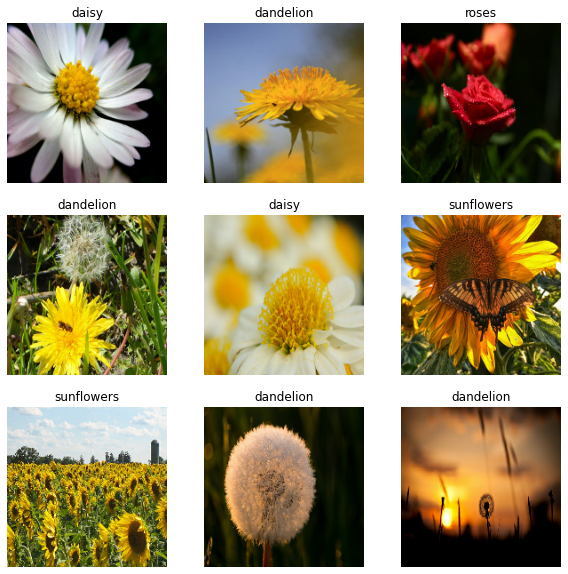

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 성능을위한 데이터 세트 구성

I / O가 차단되지 않고 디스크에서 데이터를 생성 할 수 있도록 버퍼링 된 프리 페치를 사용해야합니다. 다음은 데이터를로드 할 때 사용해야하는 두 가지 중요한 방법입니다.

`Dataset.cache()` 는 첫 번째 Epoch 동안 디스크에서로드 된 이미지를 메모리에 보관합니다. 이렇게하면 모델을 학습하는 동안 데이터 세트가 병목 현상이 발생하지 않습니다. 데이터 세트가 너무 커서 메모리에 맞지 않는 경우이 방법을 사용하여 고성능 온 디스크 캐시를 만들 수도 있습니다.

`Dataset.prefetch()` 학습 중 데이터 전처리 및 모델 실행과 겹칩니다.

관심이있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching) 에서 두 가지 방법 및 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 표준화

- RGB채널은 각각 (0, 255)의 값을 갖고있음
- 각각의 값을 (0, 1) 사이로 Rescaling( /255)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

위에서 정의한 normalization_layer는 2가지 방법을 통해 모델에 적용할 수 있다.
1. `map`함수를 통해 입력 x에 직접 normalization을 적용
2. model 생성시 layer로 추가


In [ ]:
# 1번 방법 적용 예제
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# 2. 모델 생성
## 모델 네트워크 구축
- 3개의 conv layer
  - stride = (1,1) default 값 사용
  - padding='same'
- Max pool 사용
- activation function: relu
- normaliazation layer 적용


In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일
- optimizer: `adam`
- loss: `SparseCategoricalCrossentropy`
- metrics: `accuracy'


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 요약
- 구축한 모델 네트워크 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# 3. 모델 학습 및 개선

### 모델 학습 1
- 입력 파이프라인으로 만들었던 `train_ds`와 `val_ds`를 각각 학습/평가 셋으로 사용

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 3s 28ms/step - loss: 0.5728 - accuracy: 0.7810 - val_loss: 0.7384 - val_accuracy: 0.7221
Epoch 2/10
92/92 [==============================] - 2s 27ms/step - loss: 0.5606 - accuracy: 0.7871 - val_loss: 0.7139 - val_accuracy: 0.7302
Epoch 3/10
92/92 [==============================] - 3s 27ms/step - loss: 0.5340 - accuracy: 0.8042 - val_loss: 0.7345 - val_accuracy: 0.7425
Epoch 4/10
92/92 [==============================] - 2s 27ms/step - loss: 0.5120 - accuracy: 0.8106 - val_loss: 0.7322 - val_accuracy: 0.7330
Epoch 5/10
92/92 [==============================] - 2s 27ms/step - loss: 0.5045 - accuracy: 0.8069 - val_loss: 0.7961 - val_accuracy: 0.7330
Epoch 6/10
92/92 [==============================] - 2s 27ms/step - loss: 0.4922 - accuracy: 0.8140 - val_loss: 0.7089 - val_accuracy: 0.7316
Epoch 7/10
92/92 [==============================] - 2s 27ms/step - loss: 0.4527 - accuracy: 0.8314 - val_loss: 0.7836 - val_accuracy: 0.7262
Epoch 8/10
92

## 학습 과정 시각화 1

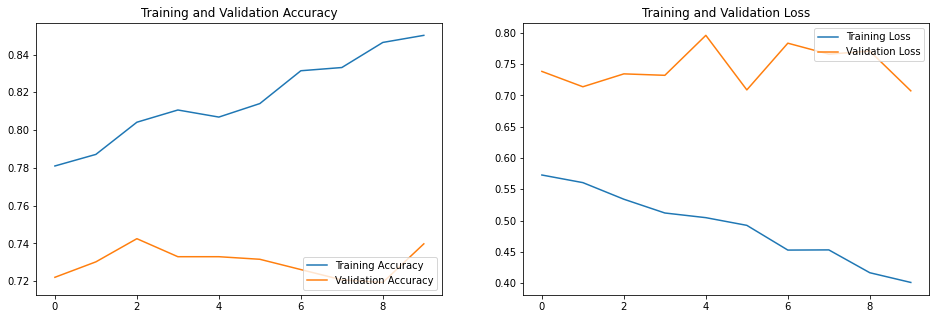

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Accuracy의 경우
  - training accuracy는 1에 가까운 모습을 보인 반면
  - val accuracy는 0.6 수준에 있는 것을 확인
- Loss의 경우
  - training loss는 지속적으로 줄어드는 반면
  - val accuracy는 초반 미세한 감소 후 증가하는 것을 확인

accuracy / loss 결과 모두 overfitting의 문제를 나타내고 있음

## Overfitting 

overfitting의 경우 다양한 이유로 인하여 발생할 수 있다.
- 데이터 불균형
- 데이터 품질 등

데이터 증강 방법과 dropout방법을 통해 과적합을 해결

### 데이터 증강

- keras에서 제공하는 [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) 방법을 이용하여 데이터를 추가로 생성

- 단순히 동일 데이터를 복제하는 것이 아닌, 데이터 회전, 확대 등의 변형을 통해 데이터를 증대



In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

증강된 데이터 확인

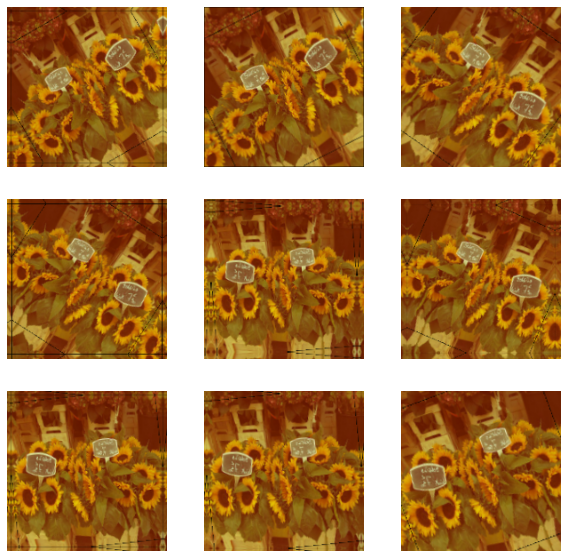

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

[Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) 은 네트워크 정규화 테크닉.

네트워크의 특정 node의 과적합을 방지하기 위하여, 모델 학습 과정에서 특정 배치의 경우 일정한 확률로 특정 node가 학습을 하지 않도록 함

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 학습 2

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history_of = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 29ms/step - loss: 1.4385 - accuracy: 0.3839 - val_loss: 1.1857 - val_accuracy: 0.4986
Epoch 2/15
92/92 [==============================] - 2s 27ms/step - loss: 1.0794 - accuracy: 0.5661 - val_loss: 1.0210 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 2s 27ms/step - loss: 0.9743 - accuracy: 0.6141 - val_loss: 0.9196 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 2s 27ms/step - loss: 0.9018 - accuracy: 0.6485 - val_loss: 0.9424 - val_accuracy: 0.6253
Epoch 5/15
92/92 [==============================] - 3s 27ms/step - loss: 0.8445 - accuracy: 0.6802 - val_loss: 0.9612 - val_accuracy: 0.6390
Epoch 6/15
92/92 [==============================] - 2s 27ms/step - loss: 0.8204 - accuracy: 0.6815 - val_loss: 1.0483 - val_accuracy: 0.5681
Epoch 7/15
92/92 [==============================] - 2s 27ms/step - loss: 0.7908 - accuracy: 0.7010 - val_loss: 0.8197 - val_accuracy: 0.6907
Epoch 8/15
92

## 학습 과정 시각화 2

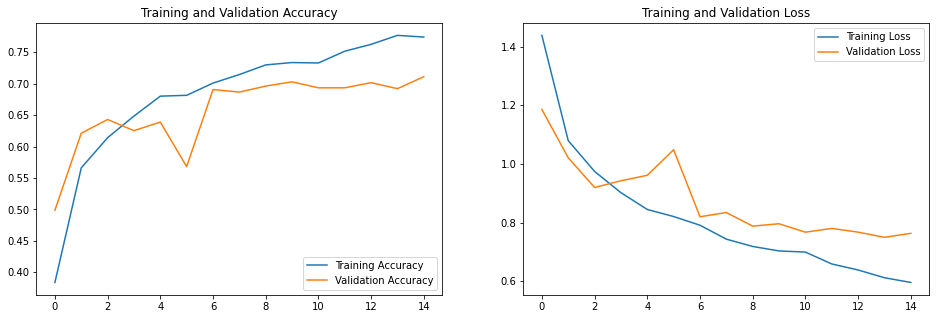

In [ ]:
acc = history_of.history['accuracy']
val_acc = history_of.history['val_accuracy']

loss = history_of.history['loss']
val_loss = history_of.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 4. 모델 예측

- red sunflower 데이터 예측 결과
- 이미지 1건에 대한 예측 결과 확인 > 입력 Pipeline을 만들지 않고 array로 전처리


In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 91.75 percent confidence.
